# EmployeePayHistory

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from urllib import parse
from sqlalchemy.exc import OperationalError
from torch.utils.data import TensorDataset, DataLoader

from common_filters import drop_sk_datetime_added_columns as drop_columns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [2]:
DB = {
    'servername' : '(local)\\SQLEXPRESS',
    'united_outdoors_database' : 'UnitedOutdoors',
}

In [3]:
params = parse.quote_plus(f'DRIVER={{SQL Server}};SERVER={DB["servername"]};DATABASE={DB["united_outdoors_database"]};Trusted_Connection=yes')
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={params}', use_setinputsizes=False, connect_args={'options': '-c search_path=dbo'}, fast_executemany=True) # setinputsizes needs to be turned off for sql server, idk why but gives errors otherwise
try:
    establish_conn = engine.connect()
    print(f'Connection to {DB["united_outdoors_database"]} database successful')
except OperationalError as e:
    print(f'Error: {e}')

Connection to UnitedOutdoors database successful


## Reading in the data

In [4]:
def read_data(sql_query):
    connection = engine.connect()
    try:
        df = pd.read_sql(sql_query, connection)
        return df
    except OperationalError as e:
        print(f'Error: {e}')
    finally:
        connection.close()
    return None

In [5]:
sql_query_employeepayhistory = "SELECT * FROM EmployeePayHistory"
employeepayhistory_df = read_data(sql_query_employeepayhistory)

employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_sk,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,EMPLOYEEPAYHISTORY_datetime_added
0,1,910,2009-01-14,125.5000,2,2024-05-21 07:52:34.377
1,2,1510,2008-01-31,63.4615,2,2024-05-21 07:52:34.377
2,3,912,2007-11-11,43.2692,2,2024-05-21 07:52:34.377
3,4,1810,2007-12-05,8.6200,2,2024-05-21 07:52:34.377
4,5,1810,2010-05-31,23.7200,2,2024-05-21 07:52:34.377


In [6]:
sql_query_businessentity = "SELECT * FROM BusinessEntity"
businessentity_df = read_data(sql_query_businessentity)

businessentity_df.head()

,BUSINESSENTITY_sk,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,BUSINESSENTITY_CONTACTTYPE_Name,BUSINESSENTITY_datetime_added
0,1,NaN,NaN,1.0,Accounting Manager,2024-05-21 07:50:10.353
1,2,1510.0,1509.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
2,3,1518.0,1517.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
3,4,1522.0,1521.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353
4,5,1528.0,1527.0,2.0,Assistant Sales Agent,2024-05-21 07:50:10.353


## Data Cleaning

In [7]:
# combining the two dataframes
employeepayhistory_df = employeepayhistory_df.merge(businessentity_df, left_on='EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', right_on='BUSINESSENTITY_sk', how='left')

# dropping the datetime_added and sk columns
drop_columns(employeepayhistory_df)

In [8]:
# dropping unnecessary columns
columns_to_drop = ['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', 'BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID', 'BUSINESSENTITY_CONTACTTYPE_Name']

employeepayhistory_df.drop(columns=columns_to_drop, inplace=True)

In [9]:
# replacing the NaN and Null values with 0
employeepayhistory_df.fillna(0, inplace=True)

# converting the columns
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'] = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'].astype(float)
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency'] = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency'].astype(int)
employeepayhistory_df['BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID'] = employeepayhistory_df['BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID'].astype(int)
employeepayhistory_df['BUSINESSENTITY_CONTACTTYPE_ContactTypeID'] = employeepayhistory_df['BUSINESSENTITY_CONTACTTYPE_ContactTypeID'].astype(int)

# Ensure the date column is in datetime format
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = pd.to_datetime(employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'])

# Convert the datetime column to number of days since Unix epoch
employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = (employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

In [10]:
# checking for any null values
employeepayhistory_df.isnull().sum()

EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate    0
EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate              0
EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency      0
BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID          0
BUSINESSENTITY_CONTACTTYPE_ContactTypeID                0
dtype: int64

In [11]:
employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID
0,14258,125.5000,2,1648,19
1,13909,63.4615,2,885,0
2,13828,43.2692,2,1658,19
3,13852,8.6200,2,1485,0
4,14760,23.7200,2,1485,0


## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [12]:
# splitting the data
X = employeepayhistory_df.drop(columns=['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'])
y = employeepayhistory_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [13]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [15]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [16]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 34.133233735410684
R2 Score: 0.47814117939648226


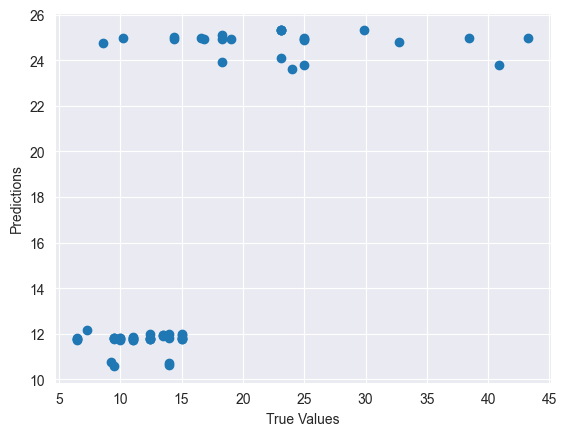

In [17]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [18]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
173,9.50,10.594862,-1.094862,1.094862,1.198723
33,12.45,11.785862,0.664138,0.664138,0.441080
165,10.00,11.767898,-1.767898,1.767898,3.125463
78,9.50,11.834928,-2.334928,2.334928,5.451887
93,13.45,11.933713,1.516287,1.516287,2.299128
...,...,...,...,...,...
132,15.00,11.818048,3.181952,3.181952,10.124820
253,9.25,10.757127,-1.507127,1.507127,2.271433
175,6.50,11.762340,-5.262340,5.262340,27.692223
225,10.00,11.752782,-1.752782,1.752782,3.072245


### Decision Tree Regressor

In [19]:
# fitting the model
dtr_model = DecisionTreeRegressor()

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [20]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [21]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 60.8087369021875
R2 Score: 0.07030268599356415


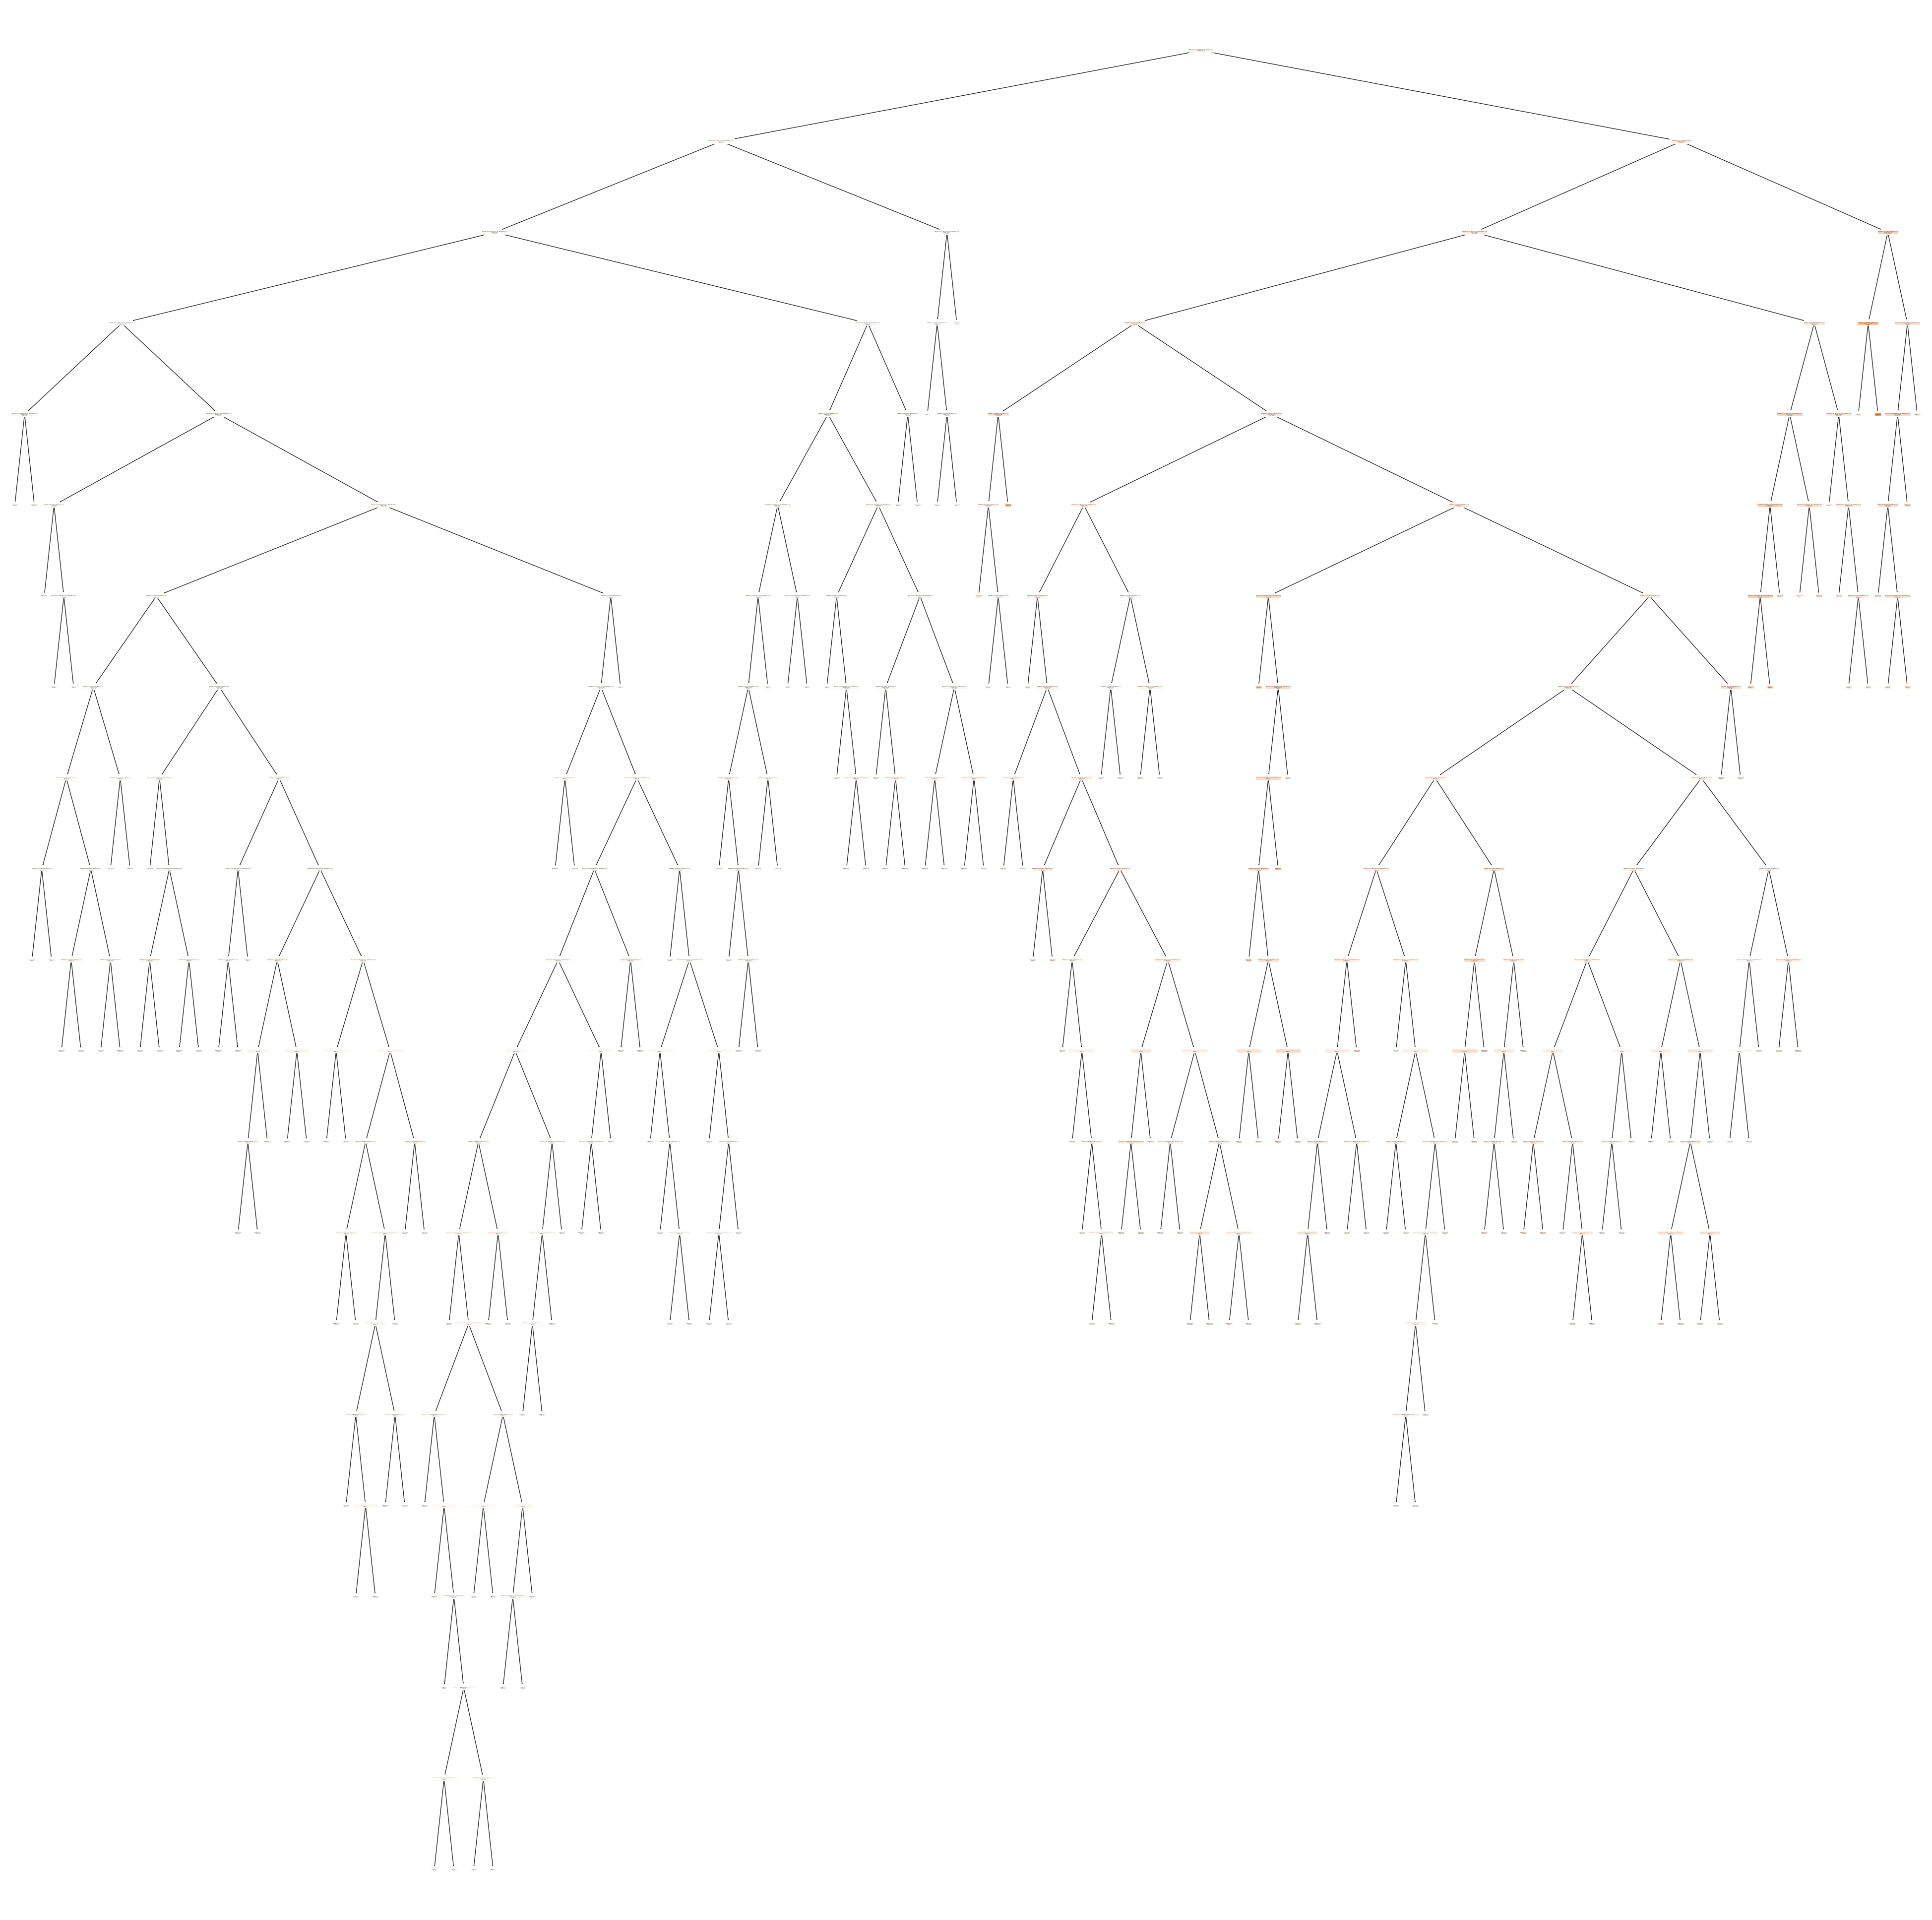

In [22]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [23]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
173,9.50,15.00,-5.50,5.50,30.2500
33,12.45,15.00,-2.55,2.55,6.5025
165,10.00,14.00,-4.00,4.00,16.0000
78,9.50,10.00,-0.50,0.50,0.2500
93,13.45,13.45,0.00,0.00,0.0000
...,...,...,...,...,...
132,15.00,15.00,0.00,0.00,0.0000
253,9.25,15.00,-5.75,5.75,33.0625
175,6.50,14.00,-7.50,7.50,56.2500
225,10.00,10.00,0.00,0.00,0.0000


### Pytorch Neural Network

In [24]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [25]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Define a function for the training loop
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 714282.875
Epoch 100, Loss: 141.94900512695312
Epoch 200, Loss: 96.82003784179688
Epoch 300, Loss: 78.07537078857422
Epoch 400, Loss: 250.02345275878906
Epoch 500, Loss: 43.67979431152344
Epoch 600, Loss: 55.2879638671875
Epoch 700, Loss: 390.2001037597656
Epoch 800, Loss: 313.3360900878906
Epoch 900, Loss: 65.41973876953125
Epoch 1000, Loss: 261.8993835449219
Epoch 1100, Loss: 93.07701110839844
Epoch 1200, Loss: 86.76233673095703
Epoch 1300, Loss: 191.79318237304688
Epoch 1400, Loss: 55.51962661743164
Epoch 1500, Loss: 156.7268829345703
Epoch 1600, Loss: 253.52394104003906
Epoch 1700, Loss: 599.2182006835938
Epoch 1800, Loss: 45.98564147949219
Epoch 1900, Loss: 122.98892974853516
Epoch 2000, Loss: 54.24050521850586
Epoch 2100, Loss: 142.1732177734375
Epoch 2200, Loss: 112.7392807006836
Epoch 2300, Loss: 122.69554138183594
Epoch 2400, Loss: 79.41149139404297
Epoch 2500, Loss: 207.39816284179688
Epoch 2600, Loss: 503.29046630859375
Epoch 2700, Loss: 93.70816802978516
Epoc

#### Calculating the metrics and visualizing the results

In [26]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 70.25047302246094
Average R2 Score: -0.07486154646621024


In [27]:
# dataframe with the predictions and the actual values, plus other metrics
#TODO